In [6]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [10]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
# dataset_meta = ['allen_'+x for x in ['B08']]
# dataset_names = [x for x in dataset_meta ]  
# raw_data_locations = [x for x in dataset_meta]
# transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

# loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
# n_datasets = len(loom_filepaths)


In [11]:
dataset_meta = 'pbmc_1k_v3'

In [18]:
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'

In [19]:
data_raw_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/adata.loom'

In [20]:
raw_data = sc.read_loom(data_raw_loc)

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [21]:
thr_lb = 1e4

In [57]:
S_tot = np.squeeze(np.asarray(raw_data.layers[spliced_layer].sum(1)))
U_tot = np.squeeze(np.asarray(raw_data.layers[unspliced_layer].sum(1)))

In [60]:
S_tot.shape

(111231,)

In [68]:
def knee_plot(umi_sum, ax1=None, thr=None, viz=False):
    n_cells = len(umi_sum)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells), usf, "k")
        ax1.set_xlabel("Cell rank")
        ax1.set_ylabel("UMI count+1")
        ax1.set_yscale("log")
    if thr is not None:
        cf = umi_sum > thr
        rank_ = np.argmin(np.abs(usf - thr))
        if viz:
            ax1.plot([0, n_cells + 1], thr * np.ones(2), "r--")
            ys = ax1.get_ylim()
            ax1.plot(rank_ * np.ones(2), ys, "r--")
        return cf


array([False, False, False, ..., False, False, False])

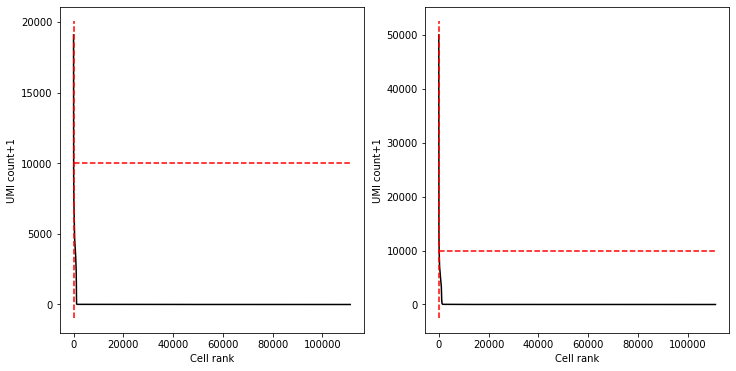

In [70]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot,ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot,ax1[1],viz=True,thr=thr_lb)


In [73]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)

In [85]:
cf = raw_data.obs['barcode'].isin(np.asarray(bcs_filtered).squeeze())

In [86]:
S_tot.shape

(111231,)

array([False, False, False, ..., False, False, False])

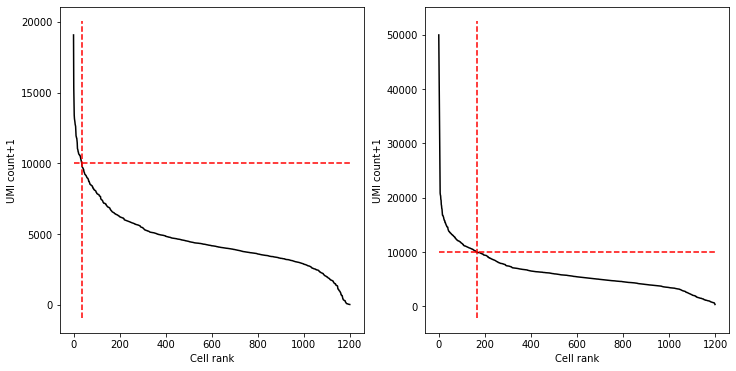

In [87]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[cf],ax1[1],viz=True,thr=thr_lb)


array([False, False, False, ..., False, False, False])

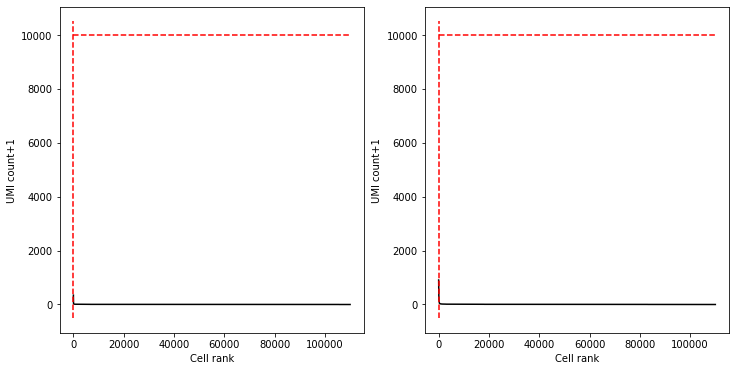

In [88]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[~cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[~cf],ax1[1],viz=True,thr=thr_lb)


In [113]:
np.var(raw_data.layers[spliced_layer][cf,:].todense(),0).shape

(1, 36601)

In [114]:
np.squeeze(np.var(raw_data.layers[spliced_layer][cf,:].todense(),0))

matrix([[0.00579931, 0.01315542, 0.00166389, ..., 0.00083265, 0.00914918,
         0.        ]], dtype=float32)

In [167]:
def plot_meanvar(X,cf_,ax):
    mean = np.squeeze(np.asarray(np.mean(X[cf_,:].todense(),0)))
    var = np.squeeze(np.asarray(np.var(X[cf_,:].todense(),0)))
    ax.scatter(mean,var,3,'k',alpha=0.4)
    xl = [min(mean),max(mean)]
    ax.plot(xl,xl,'r--')        
    ax.set_xscale("log")
    ax.set_yscale("log")

In [247]:
def plot_corr(X,Y,cf_,ax):
    corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
    mean = np.squeeze(np.asarray(np.mean(X[cf_,:].todense(),0)))
    ax.scatter(mean,corrs,3,'k',alpha=0.4)
#     xl = [min(mean),max(mean)]
#     ax.plot(xl,xl,'r--')        
    ax.set_xscale("log")
    return corrs

In [184]:
def plot_mean_bg(X,cf_,ax):
#     corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
    mean1 = np.squeeze((np.mean(X[cf_,:].toarray(),0)))
    mean2 = np.squeeze((np.mean(X[~cf_,:].toarray(),0)))
    
    lm1 = np.log10(mean1)
    lm2 = np.log10(mean2)
    gf = np.isfinite(lm1) & np.isfinite(lm2)
    
    lm1 = lm1[gf]
    lm2 = lm2[gf]
    
    ax.scatter(mean1,mean2,3,'k',alpha=0.4)
    xl = [min(mean1),max(mean1)]
    ax.plot(xl,xl,'r--')        
    ax.set_xscale("log")
    ax.set_yscale("log")
    return np.corrcoef(lm1,lm2)[0][1]

In [147]:
# raw_data.layers[unspliced_layer][cf].T[0]

<1x1200 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Column format>

Text(0, 0.5, 'Spliced/unspliced correlation')

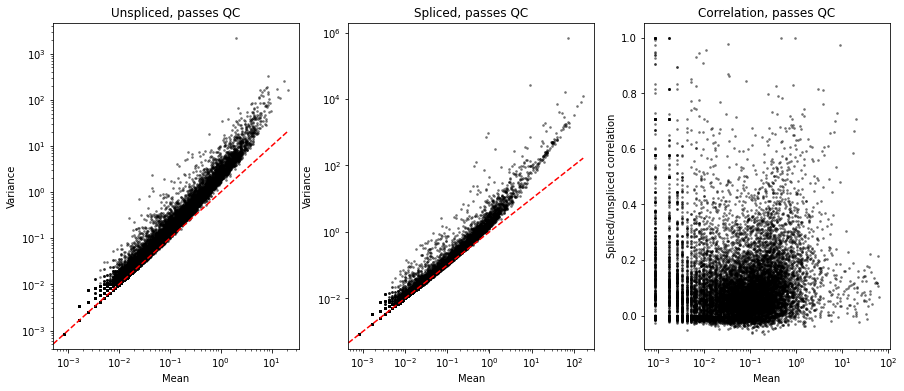

In [250]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))

plot_meanvar(raw_data.layers[unspliced_layer],cf,ax1[0])
ax1[0].set_title("Unspliced, passes QC")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(raw_data.layers[spliced_layer],cf,ax1[1])
ax1[1].set_title("Spliced, passes QC")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_qc = plot_corr(raw_data.layers[spliced_layer],raw_data.layers[unspliced_layer],cf,ax1[2])
ax1[2].set_title("Correlation, passes QC")
ax1[2].set_xlabel('Mean')
ax1[2].set_ylabel('Spliced/unspliced correlation')


Text(0, 0.5, 'Spliced/unspliced correlation')

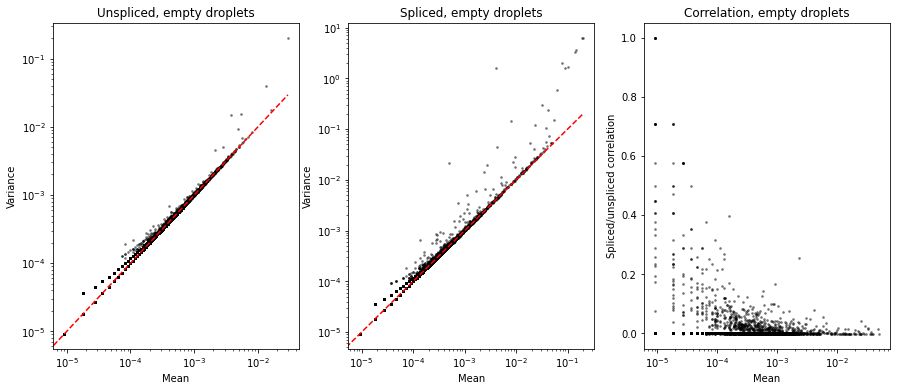

In [251]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))
plot_meanvar(raw_data.layers[unspliced_layer],~cf,ax1[0])
ax1[0].set_title("Unspliced, empty droplets")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(raw_data.layers[spliced_layer],~cf,ax1[1])
ax1[1].set_title("Spliced, empty droplets")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_empty = plot_corr(raw_data.layers[spliced_layer],raw_data.layers[unspliced_layer],~cf,ax1[2])
ax1[2].set_title("Correlation, empty droplets")
ax1[2].set_xlabel('Mean')
ax1[2].set_ylabel('Spliced/unspliced correlation')


Text(0, 0.5, 'Density')

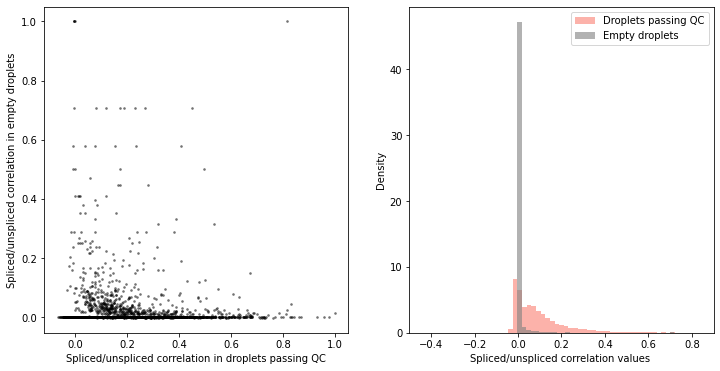

In [257]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
ax1[0].scatter(corrs_qc,corrs_empty,3,'k',alpha=0.4)
ax1[0].set_xlabel('Spliced/unspliced correlation in droplets passing QC')
ax1[0].set_ylabel('Spliced/unspliced correlation in empty droplets')

ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[1].legend()
ax1[1].set_xlim([-0.5,0.9])
ax1[1].set_xlabel('Spliced/unspliced correlation values ')
ax1[1].set_ylabel('Density')

/tmp/ipykernel_3737777/542738441.py:6: RuntimeWarning: divide by zero encountered in log10
  lm1 = np.log10(mean1)
/tmp/ipykernel_3737777/542738441.py:7: RuntimeWarning: divide by zero encountered in log10
  lm2 = np.log10(mean2)


Text(0, 0.5, 'Mean in empty droplets')

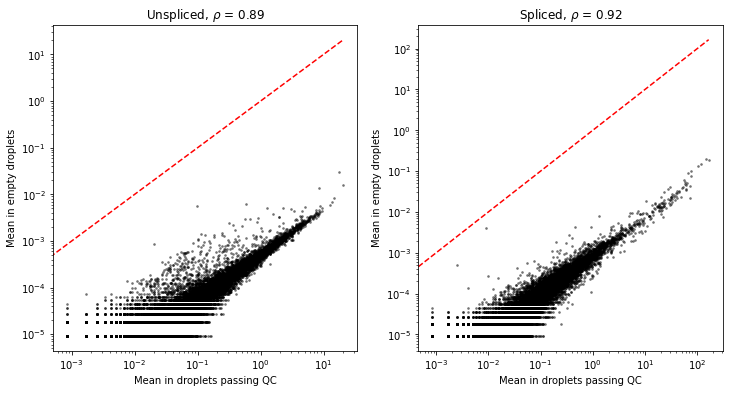

In [185]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
rho_U = plot_mean_bg(raw_data.layers[unspliced_layer],cf,ax1[0])
ax1[0].set_title(r"Unspliced, $\rho$ = {:.2f}".format(rho_U))
ax1[0].set_xlabel('Mean in droplets passing QC')
ax1[0].set_ylabel('Mean in empty droplets')

rho_S = plot_mean_bg(raw_data.layers[spliced_layer],cf,ax1[1])
ax1[1].set_title(r"Spliced, $\rho$ = {:.2f}".format(rho_S))
ax1[1].set_xlabel('Mean in droplets passing QC')
ax1[1].set_ylabel('Mean in empty droplets')

In [218]:
gf = (raw_data.layers[spliced_layer]).toarray().sum(0)>1

In [232]:
genecorr_qc = np.corrcoef(raw_data.layers[spliced_layer][cf][:,gf].T.toarray())
genecorr_qc = genecorr_qc[np.triu_indices(len(genecorr_qc),1)]

In [239]:
genecorr_empty = np.corrcoef(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())
genecorr_empty = genecorr_empty[np.triu_indices(len(genecorr_empty),1)]

Text(0, 0.5, 'Density')

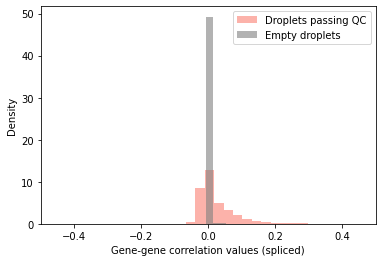

In [245]:
plt.hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (spliced)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

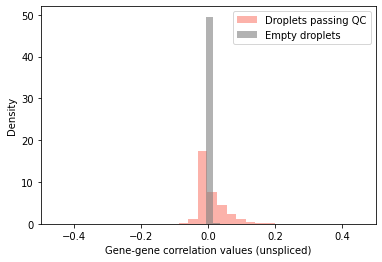

In [246]:
gf = (raw_data.layers[unspliced_layer]).toarray().sum(0)>1
genecorr_qc = np.corrcoef(raw_data.layers[unspliced_layer][cf][:,gf].T.toarray())
genecorr_qc = genecorr_qc[np.triu_indices(len(genecorr_qc),1)]
genecorr_empty = np.corrcoef(raw_data.layers[unspliced_layer][~cf][:,gf].T.toarray())
genecorr_empty = genecorr_empty[np.triu_indices(len(genecorr_empty),1)]
plt.hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (unspliced)')
plt.ylabel('Density')